# United Nations Funding Aid Report

Ian Kollipara

CS 392 Seminar in Data Science

2022.02.12

## Preprocessing

### Data Exploration

In [1]:
import polars as pl

In [2]:
df = pl.scan_csv("countries.csv")

print(df.collect())
print(df.collect().columns)

shape: (167, 10)
┌─────────────┬────────────┬─────────┬────────┬─────┬───────────┬────────────┬───────────┬───────┐
│ country     ┆ child_mort ┆ exports ┆ health ┆ ... ┆ inflation ┆ life_expec ┆ total_fer ┆ gdpp  │
│ ---         ┆ ---        ┆ ---     ┆ ---    ┆     ┆ ---       ┆ ---        ┆ ---       ┆ ---   │
│ str         ┆ f64        ┆ f64     ┆ f64    ┆     ┆ f64       ┆ f64        ┆ f64       ┆ i64   │
╞═════════════╪════════════╪═════════╪════════╪═════╪═══════════╪════════════╪═══════════╪═══════╡
│ Afghanistan ┆ 90.2       ┆ 10.0    ┆ 7.58   ┆ ... ┆ 9.44      ┆ 56.2       ┆ 5.82      ┆ 553   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ Albania     ┆ 16.6       ┆ 28.0    ┆ 6.55   ┆ ... ┆ 4.49      ┆ 76.3       ┆ 1.65      ┆ 4090  │
├╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ Algeria     ┆ 27.3       ┆ 38.4    ┆ 4.17   ┆ ... ┆ 16.1      ┆ 76.5       ┆ 2.89      ┆ 4

Upon loading the dataframe, It is imperative to find any missing values. Due to all the columns - save the country name - being numeric, there are three potential values that mean missing: NaN, null, and 0.

In [3]:
print(df.filter(
    pl.all().is_nan() &
    pl.all().is_null()
).collect())

print(df.select(pl.all() == 0).filter(pl.all() == True).collect())

shape: (0, 10)
┌─────────┬────────────┬─────────┬────────┬─────┬───────────┬────────────┬───────────┬──────┐
│ country ┆ child_mort ┆ exports ┆ health ┆ ... ┆ inflation ┆ life_expec ┆ total_fer ┆ gdpp │
│ ---     ┆ ---        ┆ ---     ┆ ---    ┆     ┆ ---       ┆ ---        ┆ ---       ┆ ---  │
│ str     ┆ f64        ┆ f64     ┆ f64    ┆     ┆ f64       ┆ f64        ┆ f64       ┆ i64  │
╞═════════╪════════════╪═════════╪════════╪═════╪═══════════╪════════════╪═══════════╪══════╡
└─────────┴────────────┴─────────┴────────┴─────┴───────────┴────────────┴───────────┴──────┘
shape: (0, 10)
┌─────────┬────────────┬─────────┬────────┬─────┬───────────┬────────────┬───────────┬──────┐
│ country ┆ child_mort ┆ exports ┆ health ┆ ... ┆ inflation ┆ life_expec ┆ total_fer ┆ gdpp │
│ ---     ┆ ---        ┆ ---     ┆ ---    ┆     ┆ ---       ┆ ---        ┆ ---       ┆ ---  │
│ bool    ┆ bool       ┆ bool    ┆ bool   ┆     ┆ bool      ┆ bool       ┆ bool      ┆ bool │
╞═════════╪════════════╪══════

This shows that there are no missing values, a luxury in this field. Now, in terms of finding correlations. It helps to plot related columns. In particular, I'm looking at two relationships: Linear and Exponential. These two help paint a picture of what columns might influence another.

In [4]:
import seaborn as sns

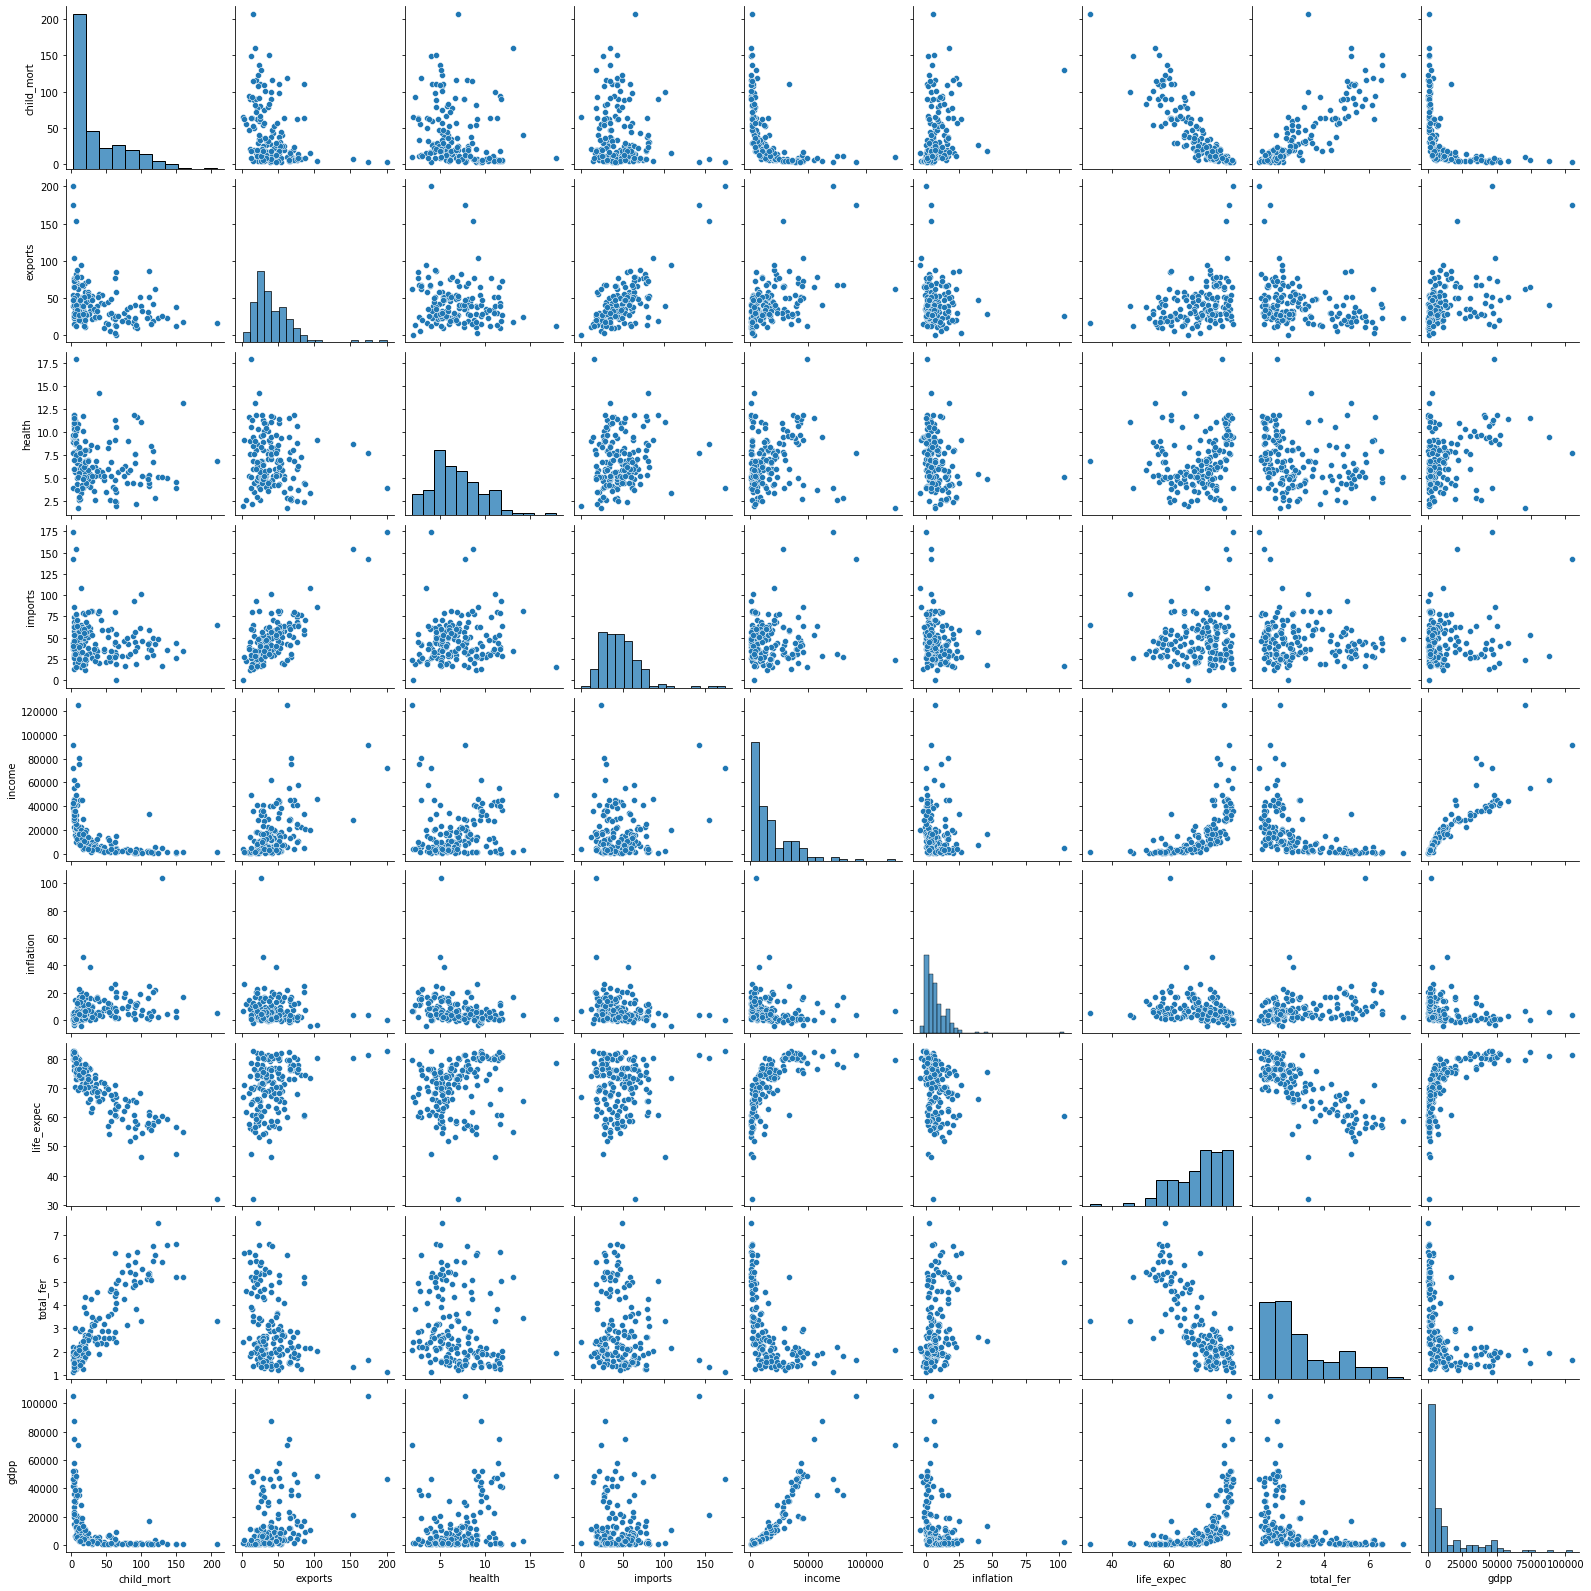

In [5]:
sns.pairplot(df.select(pl.exclude("country")).collect().to_pandas())

A few of these graphs hold weight. 
1. Income holds a strong linear correlation with GDP per Capita. 
2. Life Expectancy holds the semblence of a linear correlation with Child Mortality Rate.
3. Imports holds a strong linear correlation with Exports.
4. Child Mortality also holds a strong linear correlation with Total Fertility Rate.
5. Life Expectancy holds an exponential correlation with GDP per Capita.
6. GDP per Capita also holds an exponential correlation with Child Mortality Rate.

These correlations can then be calculated. For linear correlation I chose to find the [Pearson Correlation Coefficent](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and for Exponential I chose to find [Spearman's Rank Correlation Coeffiecent](https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient). I chose these based off I was trying to find.

The Rank Correlation describes a monotonic graph, which the exponential is, as seen in this [proof](https://www.bookofproofs.org/branches/exponential-function-is-strictly-monotonically-increasing-proof/).

In [6]:
df.select([
    pl.pearson_corr("income", "gdpp").alias("Income-GDPP Linear"),
    pl.pearson_corr("life_expec", "child_mort").alias("Life Expectency-Child Mortality Linear"),
    pl.pearson_corr("imports", "exports").alias("Imports-Exports Linear"),
    pl.pearson_corr("child_mort", "total_fer").alias("Child Mortality-Total Fertility Linear"),
    pl.spearman_rank_corr("life_expec", "gdpp").alias("Life Expectency-GDPP Rank"),
    pl.spearman_rank_corr("gdpp", "child_mort").alias("GDPP-Child Mortality Rank")
]).collect()

Income-GDPP Linear,Life Expectency-Child Mortality Linear,Imports-Exports Linear,Child Mortality-Total Fertility Linear,Life Expectency-GDPP Rank,GDPP-Child Mortality Rank
f64,f64,f64,f64,f64,f64
0.895571,-0.886676,0.737381,0.848478,0.851579,-0.876245


all of these show high correlation values, hinting at a relationship between them. What I find most interesting is the impact that GDP per Capita has. It is, by far, the most represented column in these correlations. None of these correlations are with columns that pull from the GDP per Capita. That meaning, there is no pattern that countries follow to determine where funding goes, or which sector benefits the most from an increase in GDP per Capita.

country,gdpp
str,i64
"""United States""",48400


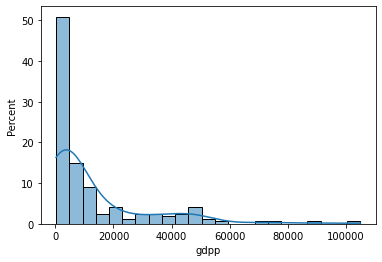

In [7]:
sns.histplot(df.collect().to_pandas(), x="gdpp", stat="percent", kde=True)
df.filter(pl.col("country") == "United States").select(pl.col(["country", "gdpp"])).collect()

This graph shows that over 50% of the values are below the US's GDP per Capita. It also identifies a few outliers.

In [8]:
df.filter(pl.col("gdpp") > 60_000).collect()

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
str,f64,f64,f64,f64,i64,f64,f64,f64,i64
"""Luxembourg""",2.8,175.0,7.77,142.0,91700,3.62,81.3,1.63,105000
"""Norway""",3.2,39.7,9.48,28.5,62300,5.95,81.0,1.95,87800
"""Qatar""",9.0,62.3,1.81,23.8,125000,6.98,79.5,2.07,70300
"""Switzerland""",4.5,64.0,11.5,53.3,55500,0.317,82.2,1.52,74600


These 4 countries all have something unique about them. In regards to Luxembourg, the country is quite small, and fairly wealth. These combine to give an incredible GDP per Capita. Qatar is an oil country, and has many of the same things as Luxembourg. Switzerland is the bank of the world, and as such there is a lot of money found within it. Norway is a bit of an odd man out, as there is no group it can be logically put into.

Regraphing this without those outliers doesn't change much, but if we choose to instead zoom in on that massive column, we get far more information.

<AxesSubplot:xlabel='gdpp', ylabel='Percent'>

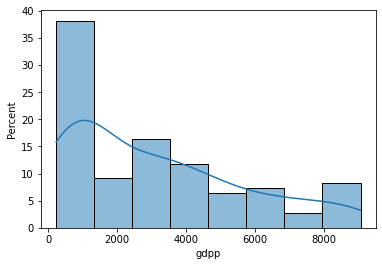

In [9]:
sns.histplot(df.filter(pl.col("gdpp") < 10_000).collect().to_pandas(), x="gdpp", stat="percent", kde=True)

This shows that a majority of the majority fall undeneath 2,000 GDP per Capita. This may not be related, but is quite sad.

### Selecting a Feature Set

Given the shown correlation values, the most important features are those that in growth. As such, I have chosen:
- Child Mortality Rate
- Life Expectancy
- Income
- GDPP
- Total Fertility Rate


In [37]:
# X = df.select(pl.col(["child_mort", "life_expec", "income", "gdpp", "total_fer"]))
X = df.select(pl.exclude("country"))

In [57]:
from scipy.stats import zscore
from sklearn.preprocessing import minmax_scale

In [58]:
X_z = X.select(
    pl.all().map(zscore)
).collect()

X_scaled = pl.DataFrame(minmax_scale(X.collect().to_numpy()), X.collect().columns)

print(X_z, X_scaled)

shape: (167, 9)
┌──────────┬────────────┬───────────┬───────────┬─────┬─────────┬──────────┬───────────┬───────────┐
│ child_mo ┆ exports    ┆ health    ┆ imports   ┆ ... ┆ inflati ┆ life_exp ┆ total_fer ┆ gdpp      │
│ rt       ┆ ---        ┆ ---       ┆ ---       ┆     ┆ on      ┆ ec       ┆ ---       ┆ ---       │
│ ---      ┆ f64        ┆ f64       ┆ f64       ┆     ┆ ---     ┆ ---      ┆ f64       ┆ f64       │
│ f64      ┆            ┆           ┆           ┆     ┆ f64     ┆ f64      ┆           ┆           │
╞══════════╪════════════╪═══════════╪═══════════╪═════╪═════════╪══════════╪═══════════╪═══════════╡
│ 1.291532 ┆ -1.1382    ┆ 0.279088  ┆ -0.082455 ┆ ... ┆ 0.15733 ┆ -1.61909 ┆ 1.902882  ┆ -0.679171 │
│          ┆            ┆           ┆           ┆     ┆ 6       ┆ 2        ┆           ┆           │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ -0.53894 ┆ -0.479658  ┆ -0.097016 ┆ 0.070837  ┆ ... ┆ -0.3123 ┆ 0.647866 

In [59]:
from sklearn.decomposition import PCA

In [72]:
pca_model = PCA(n_components=5)
X_pca = pl.DataFrame(pca_model.fit_transform(X.collect().to_pandas()), [f"pca{x}" for x in range(pca_model.n_components)])

import numpy as np

print(np.sum(pca_model.explained_variance_ratio_))

# sns.scatterplot(x="pca0", y="pca1", data=X_pca.to_pandas())

0.9999998710745572


In [73]:
from sklearn.cluster import KMeans

In [74]:
kmeans_model = KMeans(n_clusters=5)

In [75]:
kmeans_model.fit(X_z)
kmeans_model.inertia_

168.5128584023024

In [76]:
kmeans_model.fit(X_scaled)
kmeans_model.inertia_

8.634767729173188

In [77]:
kmeans_model.fit(X_pca)
kmeans_model.inertia_

0.0